# Recommender Systems: Neighborhood-Based Collaborative Filtering

This notebook is a supplementary material for the Collaborative Filtering (CF) blog post at [Encora's Insights](https://www.encora.com/insights/all). Refer to the blog post to learn more about these methods.

This notebook aims to demonstrate the strengths and limitations of neighborhood methods using a real-world dataset (Amazon Reviews). The provided code serves as a practical example for readers to better understand the concepts discussed in the blog post.

Note: Please refer to [Preprocessing.ipynb](Preprocessing.ipynb) to see how the data must be preprocessed before proceeding with this Notebook.

# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import ast
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset, Reader
from surprise.similarities import cosine
import pickle

# Configurable Notebook Variables

The variables below configure some of the processing steps performed in this Notebook.

In [2]:
SAVE_MERGE = True # if the merge between metadata and reviews should be saved
SAVE_USER_MODEL = True # save the user-based CF model
SAVE_ITEM_MODEL = True # save the item-based CF model

# Reading the data 

In [3]:
kcore_5_compact_sample = pd.read_csv('dataset/kcore_5_compact_sample.csv', names=['reviewerID', 'asin', 'overall'], quotechar='"') 
meta = pd.read_csv('dataset/metadata_sample.csv', names=['asin', 'categories', 'title', 'description', 'related'], converters={'categories': pd.eval}, quotechar='"')

Let's convert the datatypes before working with the dataframe.

In [4]:
kcore_5_compact_sample['overall'] = kcore_5_compact_sample['overall'].astype('int')
print()
print(kcore_5_compact_sample.dtypes)
kcore_5_compact_sample.head()


reviewerID    object
asin          object
overall        int32
dtype: object


,reviewerID,asin,overall
0,A2HWI21H23GDS4,0000589012,4
1,A20BIPRPD473RD,000100039X,5
2,A9WX8DK93SN5,000100039X,1
3,A2OKG8UA0G4OXS,000100039X,5
4,AU837CQMP7EDF,000100039X,5


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

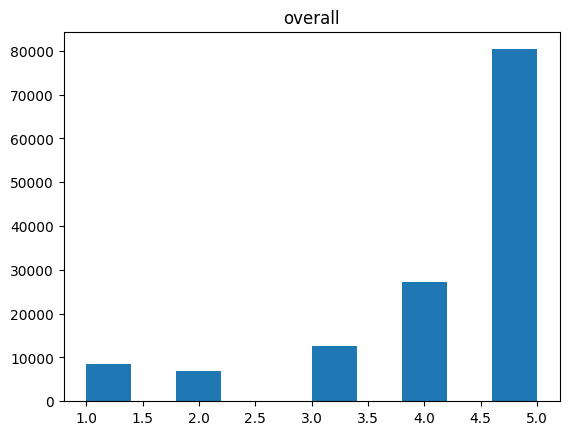

In [5]:
kcore_5_compact_sample.hist(column='overall', grid=False)

In [6]:
print(meta.dtypes)
meta.head()

asin           object
categories     object
title          object
description    object
related        object
dtype: object


,asin,categories,title,description,related
0,0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,NaN,"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
1,000100039X,[[Books]],The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
2,0002051850,[[Books]],For Whom the Bell Tolls,NaN,"{'also_bought': ['0684801469', '0743297334', '..."
3,0002007770,[[Books]],Water For Elephants,NaN,"{'also_bought': ['0399155341', '1573222453', '..."
4,0002247399,[[Books]],A Dance with Dragons,NaN,"{'also_bought': ['0553801503', '0553106635', '..."


In [7]:
meta['categories'] = meta['categories'].apply(lambda x: ', '.join([elem for list_elem in x for elem in list_elem])).astype(str)
meta['related'] = meta['related'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
print(len(meta))
meta['categories'].head()

87849


0    Movies & TV, Movies
1                  Books
2                  Books
3                  Books
4                  Books
Name: categories, dtype: object

## Joining reviews and product metadata

Neighborhood-based collaborative filtering methods require a significant amount of memory, so we reduce the dataset size to ensure the user-based and item-based matrices fits within the available memory, but we resample the data in a way we have enough of it to demonstrate the examples.

Next, we merge both the reviews and metadata samples into a single reviews sample by using the product ID.

In [8]:
try:
    reviews_sample = pd.read_json('dataset/reviews_meta_simplified.json', lines=True)    
except ValueError:
    items_count = kcore_5_compact_sample.groupby('asin').size()
    reviews_sample = kcore_5_compact_sample[kcore_5_compact_sample['asin'].isin(items_count[items_count > 1].index)]
    reviews_sample = reviews_sample[['reviewerID', 'asin', 'overall']].merge(meta, on='asin', how='inner')

if SAVE_MERGE:
    reviews_sample.to_json('dataset/reviews_meta_simplified.json', orient='records', lines=True)

reviews_sample.head()

,reviewerID,asin,overall,categories,title,description,related
0,A20BIPRPD473RD,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
1,A9WX8DK93SN5,000100039X,1,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
2,A2OKG8UA0G4OXS,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
3,AU837CQMP7EDF,000100039X,5,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."
4,A1DW9QEARBGRFO,000100039X,4,Books,The Prophet,"In a distant, timeless place, a mysterious pro...","{'also_bought': ['1851686274', '0785830618', '..."


In [9]:
items_count = reviews_sample.groupby('asin').size().sort_values()
print('Number of times the most reviewed item was reviewed: ', items_count.iloc[-1])
print('Number of times the least reviewed item was reviewed: ', items_count.iloc[0])
users_count = reviews_sample.groupby('reviewerID').size().sort_values()
print('Number of times the user that made most reviews made a review: ', users_count.iloc[-1])
print('Number of times the user that made least reviews made a review: ', users_count.iloc[0])

Number of times the most reviewed item was reviewed:  41
Number of times the least reviewed item was reviewed:  2
Number of times the user that made most reviews made a review:  159
Number of times the user that made least reviews made a review:  1


# Running recommendations with a Collaborative Filtering Recommender System

For this demonstration, we use the surprise library to implement the collaborative filtering methods. As described on its home page:

> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.
>Surprise was designed with the following purposes in mind:
>* Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
>* Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
>* Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
>* Make it easy to implement new algorithm ideas.
>* Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

First, we need to read the dataframe and build a trainset object, which contains a set of attributes that will be useful when interpreting the results of the models. This class is also used by the fit() method of every prediction algorithm from the library.  

In [10]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_sample[['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()
print(f'User-item matrix shape: {trainset.n_users} x {trainset.n_items}')

User-item matrix shape: 8440 x 12557


The utility functions below will be used to interpret the results of the algorithm when we apply it to some examples. 

In [11]:
def translate_recommendations(neighbors, user_based: bool):
    recommendations = list()
    if user_based:
        for user in neighbors:
            recommendations.append(trainset.to_raw_uid(user))
    else:
        for item in neighbors:
            recommendations.append(trainset.to_raw_iid(item))      
    return recommendations

def get_recommendations_metadata(df, user_item_column, recommendations):
    recommendation_order = dict(zip(recommendations, range(len(recommendations))))
    return df.loc[df[user_item_column].map(recommendation_order).dropna().sort_values().index]

def get_common_also_bought(also_bought, rated_item_list):
    items_also_bought = list()
    for item_also_bought in also_bought.values:
        try:
            items = item_also_bought['also_bought']
            for item in items:
                if item in rated_item_list:
                    items_also_bought.append(item)
        except:
            pass
    return [item for item in set(items_also_bought)]

# Item-based recommendations

We'll train a nearest neighbors model to do item-based recommendations, taking into account the mean ratings of each item. The KNNWithMeans class is interesting to use because it returns the mean of the ratings of a query item when it does not have enough neighbors. This parameter is defined as *min_k*, which is assigned a value of 1 by default.

This is the formula used by the **KNNWithMeans class**:

$ \large \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
N^k_u(i)} \text{sim}(i, j)} $


For the similarity measure, we use the **pearson baseline** because it is a good measure for sparse datasets. Differently from cosine, it can be used to compare the similarity between items rated at different scales, a typical case observed in how user rates content. This similarity measure in particular uses baselines for centering instead of means. To gain a deeper understanding of how baselines are calculated, see section 5.2.1 of the book [Ricci et. al. (2011). Recommender Systems Handbook] .

$\large \text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{
    \sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui}) \cdot (r_{uj} -
    b_{uj})} {\sqrt{\sum\limits_{u \in U_{ij}} (r_{ui} -  b_{ui})^2}
    \cdot \sqrt{\sum\limits_{u \in U_{ij}} (r_{uj} -  b_{uj})^2}}$


The shrinkage parameter below helps to avoid overfitting when few ratings are available. Default shrinkage is 100.

$\large \text{pearson_baseline_shrunk_sim}(i, j) = \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}$

The model will store the similarity matrix in memory.

In [12]:
try:
    KNNMeans_item = pickle.load(open('model/KNNMeans_item.models', 'rb')) 
except FileNotFoundError:
    KNNMeans_item = KNNWithMeans(sim_options = {'name': 'pearson_baseline', 'user_based': False })
    KNNMeans_item.fit(trainset)  

if SAVE_ITEM_MODEL:
    pickle.dump(KNNMeans_item, open('model/KNNMeans_item.model', 'wb'))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Cold Start problem

The cold-start problem refers to the difficulty in providing accurate recommendations for new users or items due to a lack of past data associated with them. This can be observed in this example by looking at the items in the metadata dataframe that are not present in the reviews_sample dataframe. Although these items exists in the item catalog, they will never be recommended, at this moment, due to the lack of ratings.

Here are some examples of items that are on this situation:

In [13]:
meta_merge = meta.merge(reviews_sample[['asin', 'overall']], on='asin', how='left', indicator=True)
meta_merge.query('_merge == "left_only"').drop(columns=['_merge']).head()

,asin,categories,title,description,related,overall
0,0000589012,"Movies & TV, Movies",Why Don't They Just Quit? DVD Roundtable Discu...,NaN,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
38,0002242052,Books,Without Remorse,NaN,"{'also_bought': ['0399139540', '0399133453', '...",NaN
39,0002550938,Books,Sahara (Dirk Pitt Adventure),Cussler's ( Raise the Titanic ) durable hero D...,"{'also_bought': ['0671626191', '067150374X', '...",NaN
40,0004707532,Books,Collins Gem Irish Dictionary,Text: English,"{'also_viewed': ['0007324960', '1857910478', '...",NaN
41,0005119367,"Movies & TV, TV",Joseph [VHS],"Ben Kingsley(star of 1993's Best Picture, Stev...","{'also_bought': ['6303257828', '0005119359', '...",NaN


## Predicting the rating a user would give to a item

To make use of the item-based model with a practical example, we will select a item with a fair amount of ratings. In this case, *The Hunger Games* book. 

In [14]:
n_items = len(items_count)
print(f'Number of unique items in the sample: {n_items}')
selected_item = reviews_sample[reviews_sample['title'] == 'The Hunger Games (The Hunger Games, Book 1)'].iloc[0]['asin']
meta[meta['asin'] == selected_item]

Number of unique items in the sample: 12557


,asin,categories,title,description,related
6997,0439023483,Books,"The Hunger Games (The Hunger Games, Book 1)",Starred Review.Reviewed byMegan Whalen TurnerI...,"{'also_bought': ['0439023491', '0439023513', '..."


Next, we select a user that had rated the *The Hunger Games* book with rating = 4. We'll use the model to check if it is able to predict a similar rating.

In [15]:
item_idx = trainset._raw2inner_id_items[selected_item]
user_idx = trainset.ir[item_idx][10][0]
selected_user = trainset.to_raw_uid(user_idx)
reviews_sample[reviews_sample['reviewerID'] == selected_user][82:83]

,reviewerID,asin,overall,categories,title,description,related
3938,A1G0DH7UQ4ILS6,0439023483,4,Books,"The Hunger Games (The Hunger Games, Book 1)",Starred Review.Reviewed byMegan Whalen TurnerI...,"{'also_bought': ['0439023491', '0439023513', '..."


In [16]:
KNNMeans_item.predict(selected_user, selected_item, r_ui=4)

Prediction(uid='A1G0DH7UQ4ILS6', iid='0439023483', r_ui=4, est=3.996141694807152, details={'actual_k': 15, 'was_impossible': False})

The model predicted a rating of 3.996141694807152 for this item with 15 neighbors. We could round this value and obtain a rating of 4, which is exactly how this user had rated the item.

Now we'll predict a rating for a user that hadn't rated this item previously.

For this, we'll use a item neighbor from the query item. This is done by inspecting the query item row in the similarity matrix and extracting the indices from the nonzero values (the neighbors indices).

In [17]:
KNNMeans_item.sim[item_idx].nonzero()[0][1:]

array([  10,   24,   25,   27,   56,  144,  206,  368,  439,  455,  456,
        459,  499,  509,  528,  531,  532,  606,  616,  618,  620,  645,
        861,  892,  905,  977,  980, 1023, 1046, 1053, 1066, 1212, 1276,
       1277, 1278, 1279, 1306, 1444, 1533, 1584, 1847, 1856, 1872, 2717,
       2785], dtype=int64)

Then select a user that has rated this neighbor item but not the query item (The Hunger Games book):

In [18]:
selected_user = reviews_sample[reviews_sample['asin'] == trainset.to_raw_iid(24)].iloc[0]['reviewerID']
reviews_sample[reviews_sample['reviewerID'] == selected_user]

,reviewerID,asin,overall,categories,title,description,related
123,AM74PIJBAOXJG,0007442920,5,Books,Insurgent (Divergent),"Praise for DIVERGENT: ""The next big thing."" (R...","{'also_bought': ['0062287338', '0062024035', '..."
141,AM74PIJBAOXJG,0007444117,5,Books,"Allegiant (Divergent, #3)",None,"{'also_bought': ['0007536747', '0062024043', '..."
634,AM74PIJBAOXJG,0062008110,5,Books,Wuthering Heights,The main drama in Bronte's novel happens in a ...,"{'also_bought': ['0141040386', '0141040378', '..."
655,AM74PIJBAOXJG,0062024035,5,Books,Divergent,A Q&amp;A with Author Veronica RothQ:What advi...,"{'also_bought': ['0062024043', '006202406X', '..."
5479,AM74PIJBAOXJG,0743566572,5,Books,City of Bones (Mortal Instruments),This Buffy-esque YA novel does not translate w...,"{'also_bought': ['0743572750', '0743579631', '..."
7903,AM74PIJBAOXJG,1427201412,5,Books,Austenland: A Novel,Starred Review.Katherine Kellgren gives a marv...,"{'also_bought': ['B00G7QPXAI', 'B00G7QPZKG', '..."


In [19]:
KNNMeans_item.predict(selected_user, selected_item)

Prediction(uid='AM74PIJBAOXJG', iid='0439023483', r_ui=None, est=5, details={'actual_k': 2, 'was_impossible': False})

The model predicted a rating of 5 by using two neighbors. The prediction may be imprecise due to the model relying on few neighbors.

## Using the model to recommend items similar to the selected item

To recommend items similar to *The Hunger Games*, we use the *get_neighbors* method from the item-based model. Then, we translate the model internal indices to the metadata's product ID so we can inspect them in the DataFrame:

In [20]:
raw_recommendations = KNNMeans_item.get_neighbors(item_idx, k=10)
recommended_products = translate_recommendations(raw_recommendations, user_based=False)
recommended_products

['0439023513',
 '0439023491',
 '0575081384',
 '0002247399',
 '043902353X',
 '030788743X',
 '0345803493',
 '0743597923',
 '0007442920',
 '0143170104']

In [21]:
top_recommendations = get_recommendations_metadata(meta, 'asin', recommended_products)
top_recommendations

,asin,categories,title,description,related
6998,0439023513,Books,Mockingjay (The Final Book of The Hunger Games),"Product DescriptionAgainst all odds, Katniss E...","{'also_bought': ['0439023491', '0439023483', '..."
6999,0439023491,Books,"Catching Fire (The Hunger Games, Book 2)","Starred Review. Gr 7 Up--Every year in Panem, ...","{'also_bought': ['0439023513', '0439023483', '..."
9127,0575081384,Books,The Name of the Wind,NaN,"{'also_bought': ['0756407125', '0756407915', '..."
4,0002247399,Books,A Dance with Dragons,NaN,"{'also_bought': ['0553801503', '0553106635', '..."
6996,043902353X,Books,"Catching Fire (The Hunger Games, Book 2)",NaN,"{'also_bought': ['0545663261', '0439023521', '..."
3190,030788743X,Books,Ready Player One,"Amazon Best Books of the Month, August 2011:Re...","{'also_bought': ['1476735115', '1938912306', '..."
5093,0345803493,Books,Fifty Shades Darker,THENEW YORK TIMESBESTSELLING FIFTY SHADES Tril...,"{'also_bought': ['0345803507', '0345803485', '..."
10969,0743597923,Books,Under The Dome: A Novel,Amazon Exclusive: Guillermo del Toro and Chuck...,"{'also_bought': ['1442362537', '144234430X', '..."
67,0007442920,Books,Insurgent (Divergent),"Praise for DIVERGENT: ""The next big thing."" (R...","{'also_bought': ['0062287338', '0062024035', '..."
2346,0143170104,Books,The Girl Who Played With Fire,NaN,"{'also_bought': ['0307742539', '0307949486', '..."


Notice how some of the recommendations above include sequels to the first book. 

From the "also bought" of recommended items, you are able to find the queried item, which may indicate that these recommendations makes sense.

In [22]:
also_bought = get_common_also_bought(top_recommendations['related'], [selected_item])
meta[meta['asin'].isin(also_bought)]

,asin,categories,title,description,related
6997,0439023483,Books,"The Hunger Games (The Hunger Games, Book 1)",Starred Review.Reviewed byMegan Whalen TurnerI...,"{'also_bought': ['0439023491', '0439023513', '..."


# User-based recommendations

Now we'll do the same thing, but using a user-based model.

In [23]:
try:
    KNNMeans_user = pickle.load(open('model/KNNMeans_user.models', 'rb')) 
except FileNotFoundError:
    KNNMeans_user = KNNWithMeans(sim_options = {'name': 'pearson_baseline', 'user_based': True })
    KNNMeans_user.fit(trainset)  

if SAVE_USER_MODEL:
    pickle.dump(KNNMeans_user, open('model/KNNMeans_user.model', 'wb'))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Next, we'll select a user thas has made few reviews: A3T2NQHE6CZX1B.

In [24]:
selected_user = 'A3T2NQHE6CZX1B'
reviews_sample[reviews_sample['reviewerID'] == selected_user]

,reviewerID,asin,overall,categories,title,description,related
19530,A3T2NQHE6CZX1B,B0012S4APK,3,"Electronics, Accessories & Supplies, Audio & V...",Cheetah Mounts APTMM2B Flush Tilt (1.3&quot; P...,"FITS 32-65"" TVSThis mount fits essentially all...","{'also_bought': ['B000IKK0OI', 'B00GTE0VJ6', '..."
31282,A3T2NQHE6CZX1B,B0096YOQRY,1,"Electronics, Television & Video, Televisions, ...",VIZIO E320i-A0 32-inch 720p 60Hz LED Smart HDT...,None,"{'also_bought': ['B00CUTJ7EE', 'B0043BX96Y', '..."


Since the user has given few reviews, it doesn't have any common neighbors for the model to make recommendations. This is another example of how the cold-start problem affects the prediction. 

In [25]:
KNNMeans_user.predict(selected_user, selected_item)

Prediction(uid='A3T2NQHE6CZX1B', iid='0439023483', r_ui=None, est=2.0, details={'actual_k': 0, 'was_impossible': False})

Since there are no neighbors, the KNNMeans model returns the mean ratings of the user.

In [26]:
reviews_sample[reviews_sample['reviewerID'] == selected_user]['overall'].mean() == KNNMeans_user.predict(selected_user, selected_item)[3]

True

## Comparing the ratings between the item-based and user-based models

We can apply the user-based model to the same user as before and see how the model predicts the rating of *The Hunger Games*, which has been given a rating of 4.

In [27]:
selected_user = trainset.to_raw_uid(user_idx)
reviews_sample[reviews_sample['reviewerID'] == selected_user][82:83]

,reviewerID,asin,overall,categories,title,description,related
3938,A1G0DH7UQ4ILS6,0439023483,4,Books,"The Hunger Games (The Hunger Games, Book 1)",Starred Review.Reviewed byMegan Whalen TurnerI...,"{'also_bought': ['0439023491', '0439023513', '..."


In [28]:
KNNMeans_user.predict(selected_user, selected_item, r_ui=4)

Prediction(uid='A1G0DH7UQ4ILS6', iid='0439023483', r_ui=4, est=4.019804082711727, details={'actual_k': 5, 'was_impossible': False})

We see that the item-based model has given a closer estimate to the real rating compared to the user-based model (3.996141694807152 vs 4.019804082711727), but both were very close to the real rating given by this user.

## Using the model to recommend users similar to a given user

In some situations, it might be useful to recommend similar users to a user at hand. This is the case of recommender engines used in the context of social networks, for example.

In this case, we'll select a user with more than 150 ratings and try to recommend a similar user to it.

In [29]:
selected_user = users_count[users_count > 150].index[0]
reviews_very_active_user = reviews_sample[reviews_sample['reviewerID'] == selected_user]
reviews_very_active_user.shape

(156, 7)

In [30]:
reviews_very_active_user.head()

,reviewerID,asin,overall,categories,title,description,related
717,A2Y3ZGVRA3S23L,0062076108,5,Books,Twice Tempted (Night Prince),Readers are in for a story that is emotionally...,"{'also_bought': ['006178320X', '0061783161', '..."
721,A2Y3ZGVRA3S23L,0062076116,5,Books,Up from the Grave (Night Huntress),"""Leavened with strong emotion and dark humor, ...","{'also_bought': ['0061783196', '0061783188', '..."
817,A2Y3ZGVRA3S23L,0062267159,5,Books,Clash (Crash),"On again, off again. Together. Apart. The only...","{'also_bought': ['0062267175', '0062267140', '..."
819,A2Y3ZGVRA3S23L,0062267175,5,Books,Crush,Football glory. A giant diamond. A wandering e...,"{'also_bought': ['0062267159', '0062267140', '..."
864,A2Y3ZGVRA3S23L,0062294776,4,Books,Wait for You,A young woman must come to terms with the secr...,"{'also_bought': ['0062304828', '0062294784', '..."


Recommending the top 3 most similar users:

In [31]:
user_idx = trainset._raw2inner_id_users[selected_user]
raw_top_recommendations = KNNMeans_user.get_neighbors(user_idx, k=3)
recommended_users = translate_recommendations(raw_top_recommendations, user_based=True)
recommended_users

['A1SNDEL69MX6SX', 'AUZ96COITGKE3', 'A1119PAA9HZJ27']

Let's check the products the most similar user has bought in common with the queried user. They're all books:

In [32]:
recommended_user_reviews = reviews_sample[reviews_sample['reviewerID'] == recommended_users[0]]
reviews_very_active_user[reviews_very_active_user['asin'].isin(recommended_user_reviews['asin'])]

,reviewerID,asin,overall,categories,title,description,related
3854,A2Y3ZGVRA3S23L,042526596X,5,Books,Gabriel's Inferno,None,"{'also_bought': ['140591243X', '1405912456', '..."
3861,A2Y3ZGVRA3S23L,0425266516,5,Books,Gabriel's Redemption (Gabriel's Inferno Trilogy),None,"{'also_bought': ['0425265951', '042526596X', '..."
7258,A2Y3ZGVRA3S23L,0988715805,5,Books,Allure: A Spiral of Bliss Novel (Book Two),I LOVED THIS BOOK! Just beautiful! Dean and Li...,"{'also_bought': ['0988715880', '098871583X', '..."
7260,A2Y3ZGVRA3S23L,098871583X,5,Books,Arouse: A Spiral of Bliss Novel (Book One) (Vo...,None,"{'also_bought': ['0988715880', '0988715805', '..."
7337,A2Y3ZGVRA3S23L,0989450252,5,Books,Crashed (The Driven Trilogy),K. Bromberg is that reserved woman sitting in ...,"{'also_bought': ['0989450236', '098945021X', '..."
10074,A2Y3ZGVRA3S23L,1495912183,5,Books,Moore than Forever (Needing Moore Series) (Vol...,None,"{'also_bought': ['1492769339', '0615796982', '..."
11066,A2Y3ZGVRA3S23L,1939927196,5,Books,A Love Like This,None,"{'also_bought': ['1938701062', '1937698971', '..."


Also, 60 products the user already rated appear on the *also bought* attribute of the recommended user's product list:

In [33]:
also_bought = get_common_also_bought(recommended_user_reviews['related'], list(reviews_very_active_user['asin']))
meta[meta['asin'].isin(also_bought)]['asin'].count()

60

# Conclusion 

In this notebook, we presented an implementation of item-based and user-based Collaborative Filtering models and applied it to predict ratings and recommend top similar users/items using a real-world dataset.

Check out the other Notebooks in the repository to learn more about Recommender Systems.